In [ ]:
#All necessary imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sn
from mpl_toolkits import mplot3d
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import math

In [ ]:
#combining all csv files in single file to merge all data

In [4]:
for i in range(0,112):
    df = pd.read_csv("D:/BEPROJECT/daily_dataset/daily_dataset/block_"+str(i)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv("hc_"+str(i)+".csv")
    
fout = open("energy1.csv", "a")
for line in open("hc_0.csv"):
    fout.write(line)
for num in range(0,112):
    f = open("hc_"+str(num)+".csv")
    f.readline() # skip the header
    for line in f:
         fout.write(line)
    f.close()
fout.close()

In [ ]:
#length of dataset

In [2]:
electricity = pd.read_csv('energy1.csv')
len(electricity)

3536007

In [195]:
#grouping number of houses per day

In [3]:
housecount = electricity.groupby('day')[['LCLid']].nunique()
housecount.head(5)

,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41
2011-11-27,41


Text(0.5, 1.0, 'House Count')

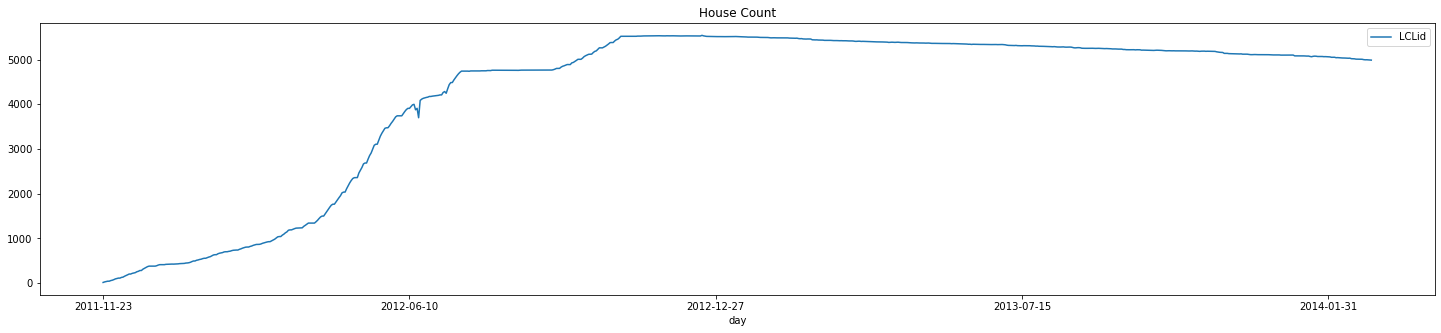

In [4]:
housecount.plot(figsize=(25,5))
plt.title("House Count")

In [5]:
#combining total electricity usage per day by all houses

In [6]:
electricity = electricity.groupby('day')[['energy_sum']].sum()
electricity = electricity.merge(housecount, on = ['day'])
electricity = electricity.reset_index()

In [7]:
electricity.head()

,day,energy_sum,LCLid
0,2011-11-23,90.385000,13
1,2011-11-24,213.412000,25
2,2011-11-25,303.993000,32
3,2011-11-26,420.976000,41
4,2011-11-27,444.883001,41


In [8]:
#creating average energy

In [9]:
electricity.day = pd.to_datetime(electricity.day,format='%Y-%m-%d').dt.date
electricity['avg_energy'] =  electricity['energy_sum']/electricity['LCLid']
electricity = electricity.drop(index=828, axis = 0)
print("First Day: ",min(electricity.day))
print("Last Day: ",max(electricity.day))

electricity.to_csv('project.csv')

First Day:  2011-11-23
Last Day:  2014-02-27


In [10]:
electricity.head(5)

,day,energy_sum,LCLid,avg_energy
0,2011-11-23,90.385000,13,6.952692
1,2011-11-24,213.412000,25,8.536480
2,2011-11-25,303.993000,32,9.499781
3,2011-11-26,420.976000,41,10.267707
4,2011-11-27,444.883001,41,10.850805


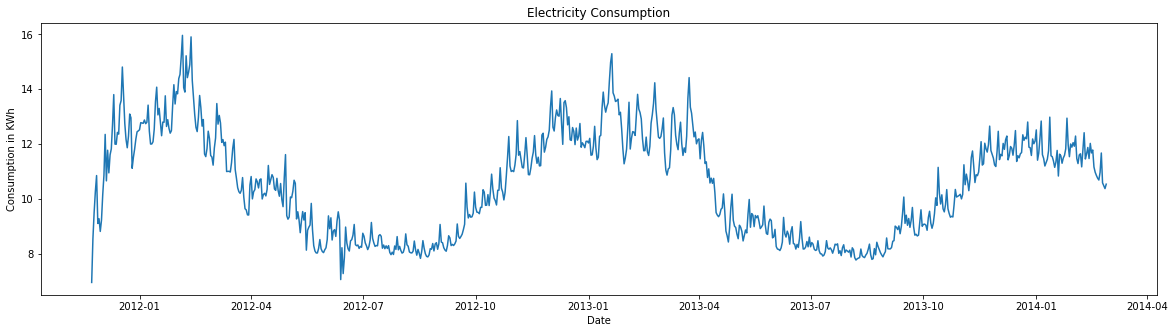

In [11]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1 = plt.plot(electricity.day, electricity.avg_energy)
plt.ylabel("Consumption in KWh")
plt.xlabel("Date")
plt.title('Electricity Consumption')
plt.show()

In [12]:
#importing weather data

In [13]:
weather = pd.read_csv('D:/BEPROJECT/weather_daily_darksky.csv')
weather.columns

Index(['temperatureMax', 'temperatureMaxTime', 'windBearing', 'icon',
       'dewPoint', 'temperatureMinTime', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureMinTime', 'apparentTemperatureHigh', 'precipType',
       'visibility', 'humidity', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'time',
       'sunsetTime', 'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'sunriseTime', 'temperatureHighTime', 'uvIndexTime', 'summary',
       'temperatureLowTime', 'apparentTemperatureMin',
       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime',
       'moonPhase'],
      dtype='object')

In [14]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

In [15]:
#combining weather and electricity dataframes

In [16]:
weather_electricity =  electricity.merge(weather,on='day')
weather_electricity

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385000,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,...,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412000,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,...,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97
2,2011-11-25,303.993000,32,9.499781,13.03,243,7.24,0.48,5.02,1024.47,...,12.38,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01
3,2011-11-26,420.976000,41,10.267707,12.96,237,6.96,0.44,5.75,1025.80,...,13.07,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05
4,2011-11-27,444.883001,41,10.850805,13.54,256,5.76,0.42,5.48,1021.11,...,13.08,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,2014-02-23,58345.432995,4998,11.673756,11.94,200,6.17,0.66,7.10,1010.37,...,12.33,0.76,5.52,11.94,1.0,7.99,8.67,11.94,5.53,0.78
823,2014-02-24,52867.660004,4994,10.586235,14.23,183,6.03,0.50,5.02,1005.19,...,13.00,0.74,4.78,14.23,1.0,8.25,7.99,14.23,5.52,0.82
824,2014-02-25,52330.109999,4995,10.476498,11.43,202,5.06,0.62,5.69,1000.65,...,12.09,0.78,1.67,11.43,1.0,4.17,6.79,10.31,3.89,0.86
825,2014-02-26,51804.199995,4993,10.375366,11.29,227,2.74,0.26,3.82,1012.73,...,13.00,0.73,3.03,11.29,2.0,6.01,4.17,11.29,1.67,0.90


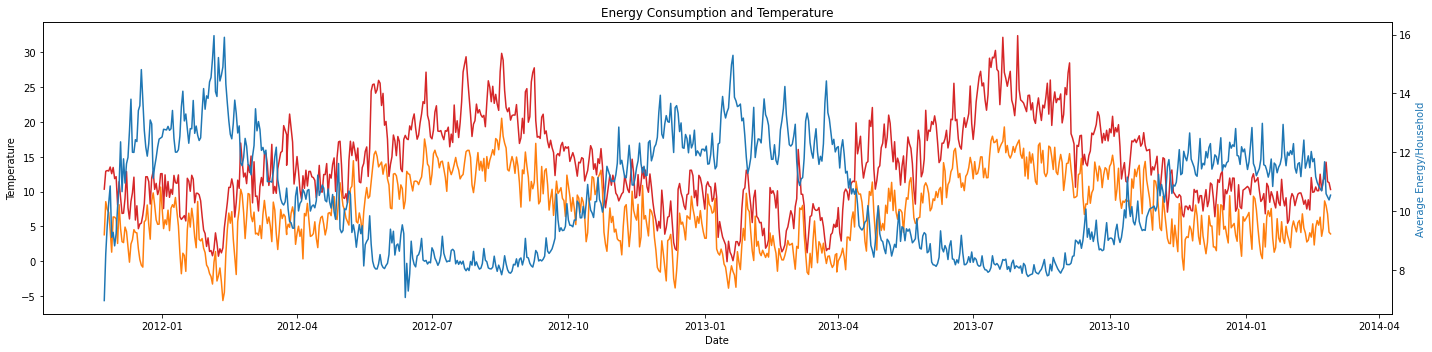

In [17]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_electricity.day, weather_electricity.temperatureMax, color = 'tab:red')
ax1.plot(weather_electricity.day, weather_electricity.temperatureMin, color = 'tab:orange')
ax1.set_ylabel('Temperature')
ax1.set_xlabel('Date')
#ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_electricity.day,weather_electricity.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
#ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

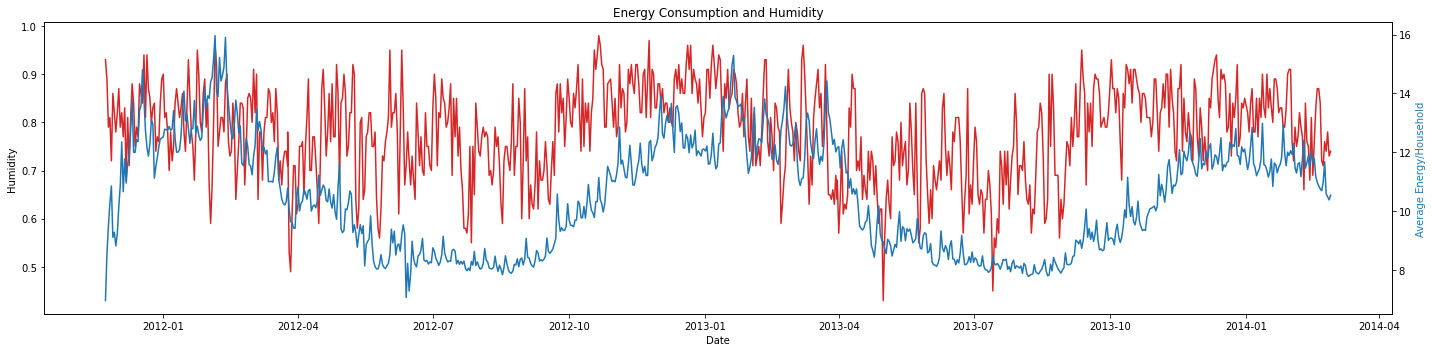

In [18]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_electricity.day, weather_electricity.humidity, color = 'tab:red')
ax1.set_ylabel('Humidity')
ax1.set_xlabel('Date')
ax2 = ax1.twinx()
ax2.plot(weather_electricity.day,weather_electricity.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

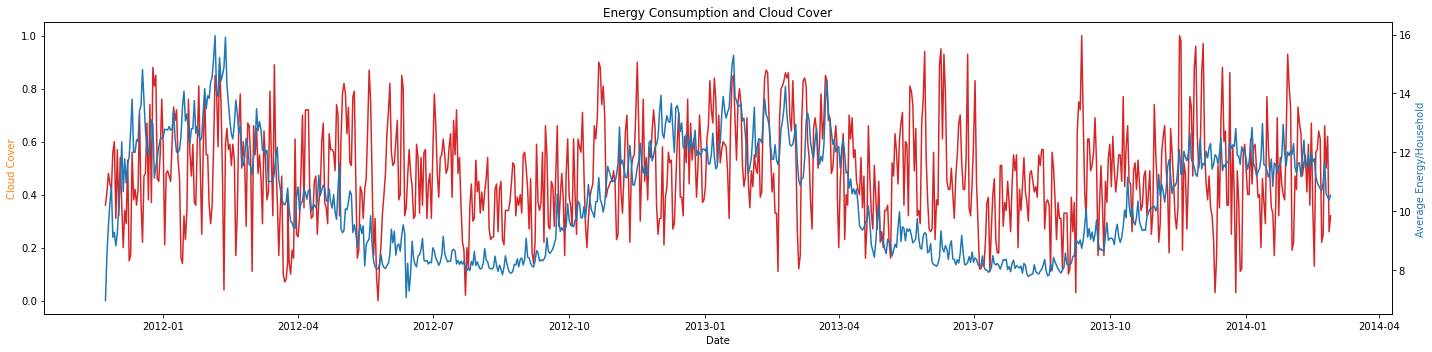

In [19]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_electricity.day, weather_electricity.cloudCover, color = 'tab:red')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')
ax1.set_xlabel('Date')
ax2 = ax1.twinx()
ax2.plot(weather_electricity.day,weather_electricity.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

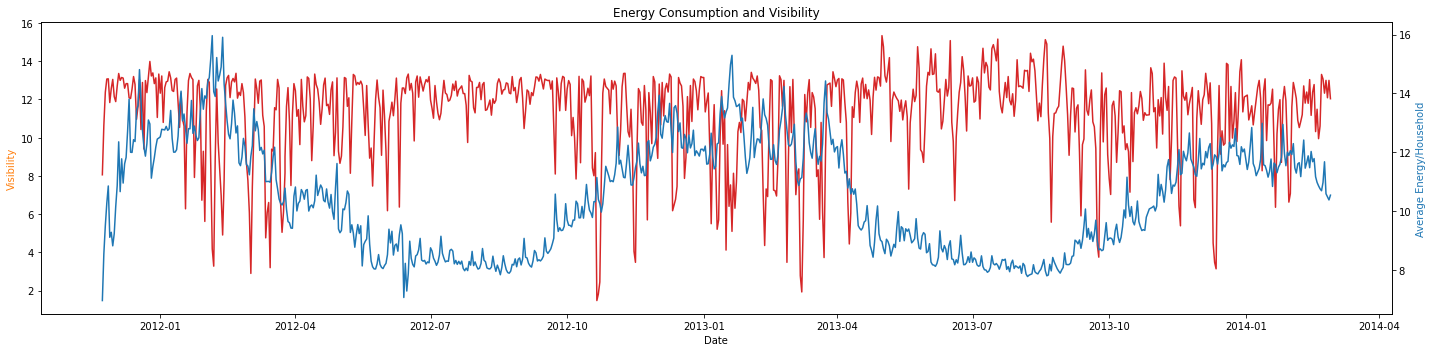

In [20]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_electricity.day, weather_electricity.visibility, color = 'tab:red')
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax1.set_xlabel('Date')
ax2 = ax1.twinx()
ax2.plot(weather_electricity.day,weather_electricity.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

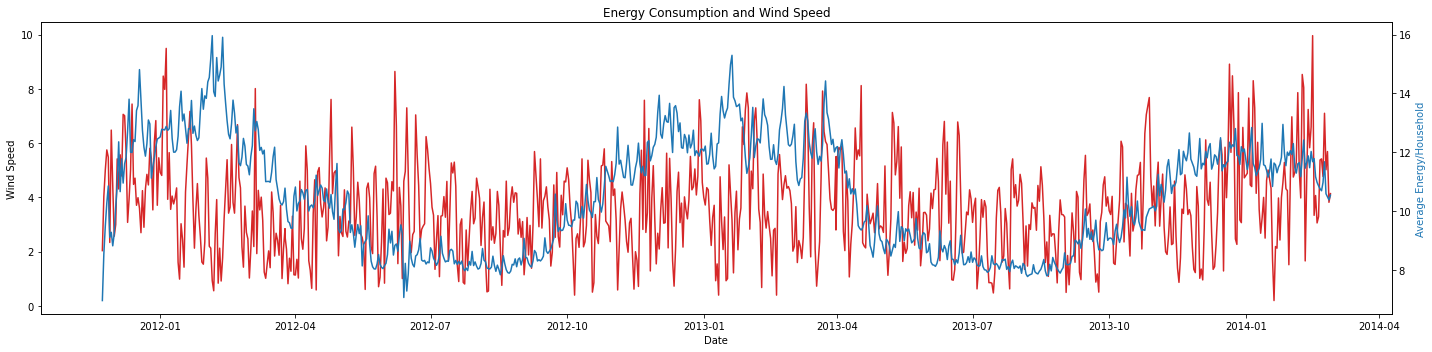

In [21]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_electricity.day, weather_electricity.windSpeed, color = 'tab:red')
ax1.set_ylabel('Wind Speed')
ax1.set_xlabel('Date')
ax2 = ax1.twinx()
ax2.plot(weather_electricity.day,weather_electricity.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

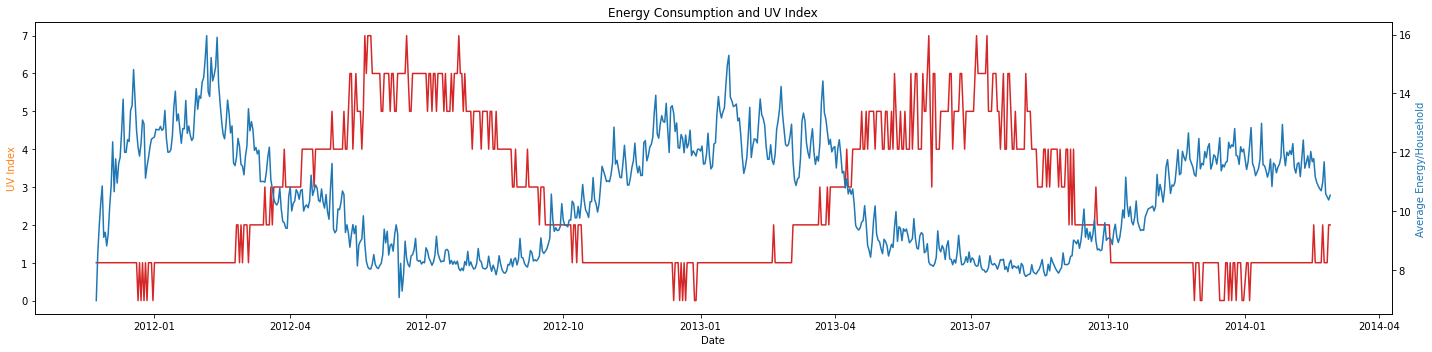

In [22]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_electricity.day, weather_electricity.uvIndex, color = 'tab:red')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax1.set_xlabel('Date')
ax2 = ax1.twinx()
ax2.plot(weather_electricity.day,weather_electricity.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

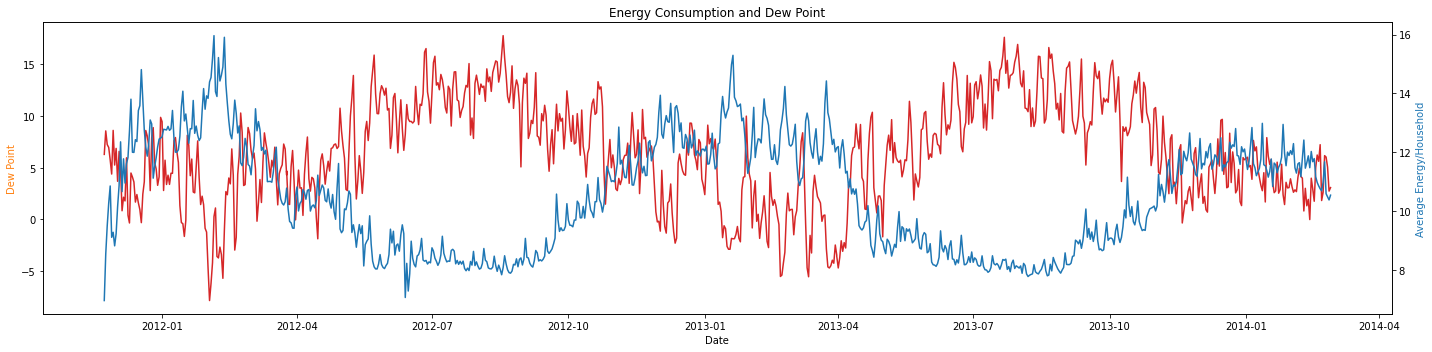

In [23]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_electricity.day, weather_electricity.dewPoint, color = 'tab:red')
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax1.set_xlabel('Date')
ax2 = ax1.twinx()
ax2.plot(weather_electricity.day,weather_electricity.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

In [24]:
#feature selection for weather data

In [25]:
cor_matrix = weather_electricity[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix


,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.869525,-0.774501,0.252937,0.147088,-0.038493,-0.252314,0.373549,-0.752491,-0.021496
temperatureMax,-0.869525,1.000000,0.864971,-0.332606,-0.154720,0.117488,0.259013,-0.404300,0.696193,0.005616
dewPoint,-0.774501,0.864971,1.000000,-0.024389,-0.092949,-0.029314,0.042465,0.056265,0.486329,-0.006878
cloudCover,0.252937,-0.332606,-0.024389,1.000000,0.171362,-0.099611,-0.330125,0.479537,-0.247926,-0.064224
windSpeed,0.147088,-0.154720,-0.092949,0.171362,1.000000,-0.346191,0.280997,-0.041615,-0.153583,-0.021748
pressure,-0.038493,0.117488,-0.029314,-0.099611,-0.346191,1.000000,-0.012877,-0.249943,0.099523,0.041256
visibility,-0.252314,0.259013,0.042465,-0.330125,0.280997,-0.012877,1.000000,-0.578175,0.240376,0.063339
humidity,0.373549,-0.404300,0.056265,0.479537,-0.041615,-0.249943,-0.578175,1.000000,-0.533515,-0.015682
uvIndex,-0.752491,0.696193,0.486329,-0.247926,-0.153583,0.099523,0.240376,-0.533515,1.000000,0.014541
moonPhase,-0.021496,0.005616,-0.006878,-0.064224,-0.021748,0.041256,0.063339,-0.015682,0.014541,1.000000


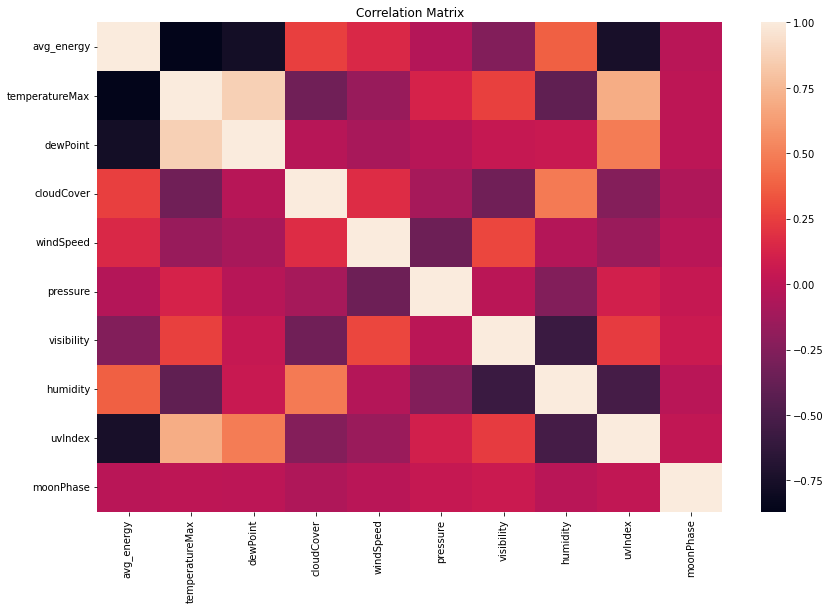

In [26]:
fig, ax1 = plt.subplots(figsize = (14,9))
hm = sn.heatmap(data = weather_electricity[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr())
plt.title('Correlation Matrix')
plt.show()

In [27]:
#from correlation matrix it is clear that remperatureMax, humidity and windspeed are highly correlated with the target feature

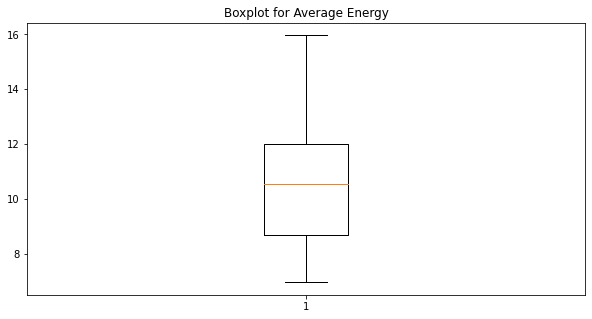

In [28]:
fig, ax1 = plt.subplots(figsize = (10,5))
plt.title('Boxplot for Average Energy')
plt.boxplot(weather_electricity[['avg_energy']])
plt.show()

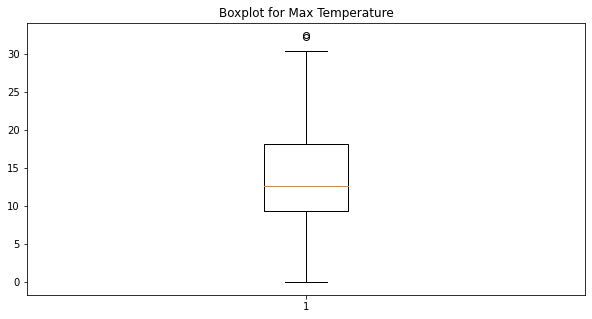

In [29]:
fig, ax1 = plt.subplots(figsize = (10,5))
plt.title('Boxplot for Max Temperature')
plt.boxplot(weather_electricity[['temperatureMax']])
plt.show()

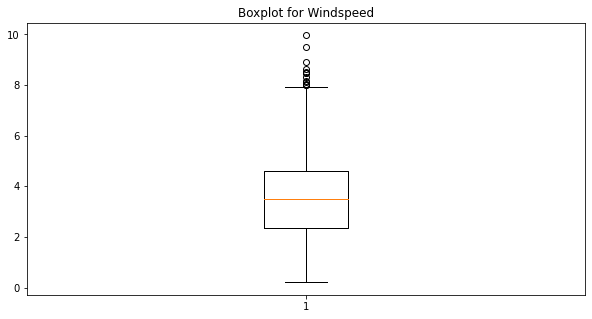

In [30]:
fig, ax1 = plt.subplots(figsize = (10,5))
plt.title('Boxplot for Windspeed')
plt.boxplot(weather_electricity[['windSpeed']])
plt.show()

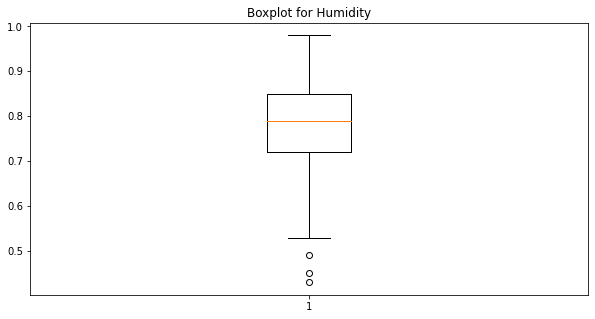

In [31]:
fig, ax1 = plt.subplots(figsize = (10,5))
plt.title('Boxplot for Humidity')
plt.boxplot(weather_electricity[['humidity']])
plt.show()

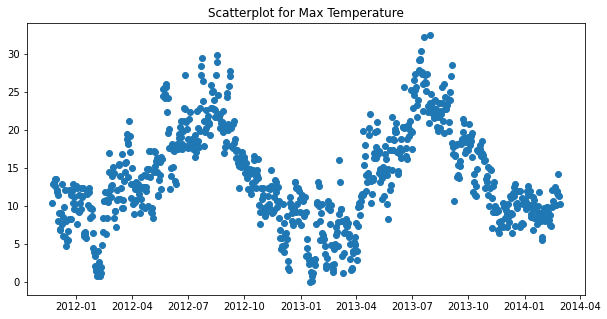

In [32]:
fig, ax1 = plt.subplots(figsize = (10,5))
plt.title('Scatterplot for Max Temperature')
plt.scatter(weather_electricity[['day']],weather_electricity[['temperatureMax']])
plt.show()


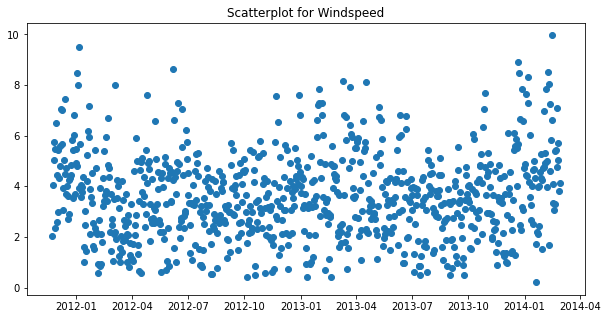

In [33]:
fig, ax1 = plt.subplots(figsize = (10,5))
plt.title('Scatterplot for Windspeed')
plt.scatter(weather_electricity[['day']],weather_electricity[['windSpeed']])
plt.show()

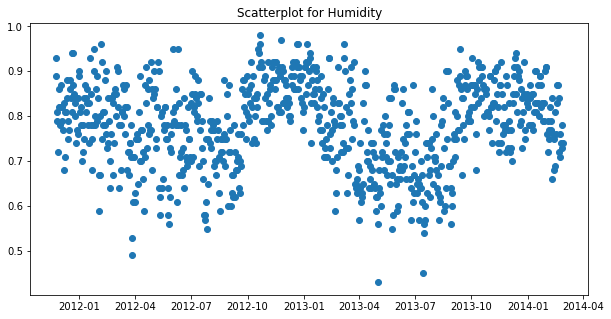

In [34]:
fig, ax1 = plt.subplots(figsize = (10,5))
plt.title('Scatterplot for Humidity')
plt.scatter(weather_electricity[['day']],weather_electricity[['humidity']])
plt.show()

In [35]:
#forming weather clusters to simulate the weather on a particular day based on weather features

In [36]:
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_electricity[['temperatureMax','humidity','windSpeed']])

print(weather_scaled)

[[0.32101047 0.90909091 0.18852459]
 [0.40018484 0.83636364 0.39344262]
 [0.40326556 0.65454545 0.49385246]
 ...
 [0.35397412 0.63636364 0.5625    ]
 [0.34966112 0.54545455 0.37090164]
 [0.31947012 0.56363636 0.40368852]]


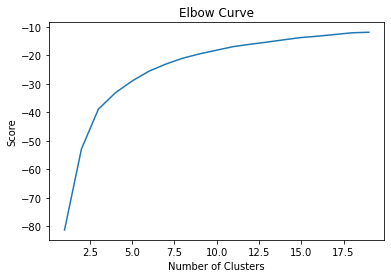

In [37]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [38]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_electricity['weather_cluster'] = kmeans.labels_
print(weather_electricity['weather_cluster'])

0      1
1      1
2      0
3      0
4      0
      ..
822    0
823    0
824    0
825    0
826    0
Name: weather_cluster, Length: 827, dtype: int32


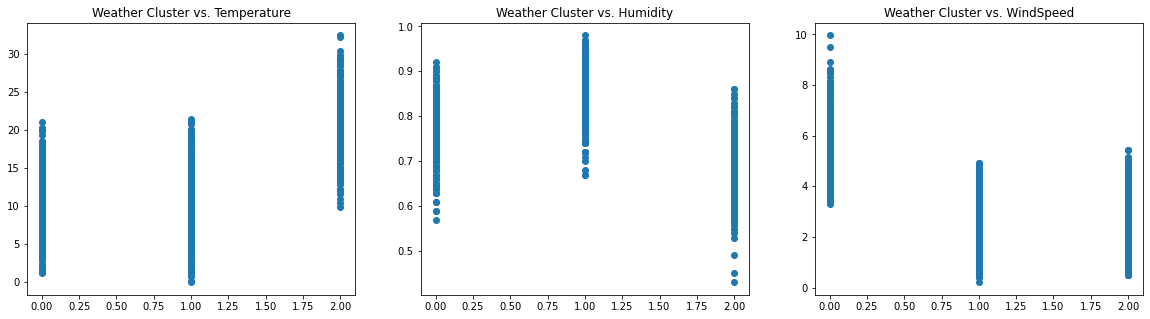

In [39]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_electricity.weather_cluster,weather_electricity.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_electricity.weather_cluster,weather_electricity.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_electricity.weather_cluster,weather_electricity.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()

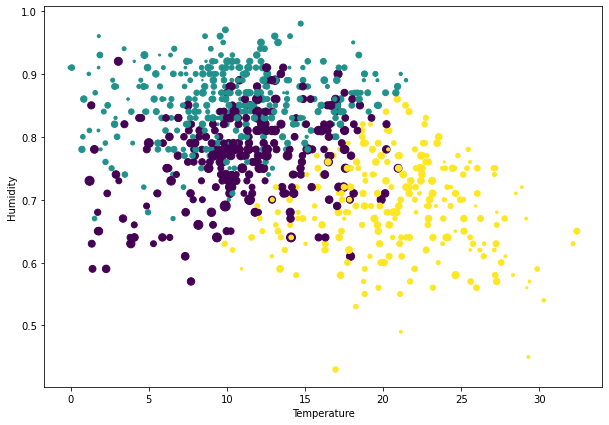

In [40]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_electricity.temperatureMax, 
            weather_electricity.humidity, 
            s = weather_electricity.windSpeed*10,
            c = weather_electricity.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

In [41]:
#train test split

In [42]:
weather_electricity['Year'] = pd.DatetimeIndex(weather_electricity['day']).year  
weather_electricity['Month'] = pd.DatetimeIndex(weather_electricity['day']).month
weather_electricity.set_index(['day'],inplace=True)

In [43]:
weather_electricity.to_csv("weather_electricity.csv")

In [44]:
model_data = weather_electricity[['avg_energy','weather_cluster']]
model_data.head(10)
#train = model_data.iloc[0:round(len(model_data)*0.67)]
#test = model_data.iloc[len(train)-1:round(len(train)+len(model_data)*0.33)]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data))]

In [45]:
print("NO OF TEST DAYS: ",len(test))

NO OF TEST DAYS:  30


In [46]:
#TimeSeriesSplit Cross Validation for Hyperparameter Selection

In [47]:
result = []
for i in range(2,10,2):
    train1 = model_data.iloc[0:round(len(model_data)*i/10)]
    test1 = model_data.iloc[len(train1)-1:round(len(train1)+len(model_data)*0.20)]
    endog = train1['avg_energy']
    exog = sm.add_constant(train1[['weather_cluster']])
    mod = sm.tsa.statespace.SARIMAX(endog = endog,exog = exog, order=(7,1,7),seasonal_order=(1,1,0,12))
    model_fit = mod.fit()
    predict = model_fit.predict(start = len(train1),end = len(train1)+len(test1)-1,exog = sm.add_constant(test1[['weather_cluster']]))
    test1['predicted'] = predict.values
    test1['residual'] = abs(test1['avg_energy']-test1['predicted'])
    MAPE = (abs(test1['residual'])/test1['avg_energy']).sum()*100/len(test1)
    result.append(MAPE)
#print(result)
print(np.average(result))

23.69672513563264


Text(0.5, 0, 'Train-Test Split')

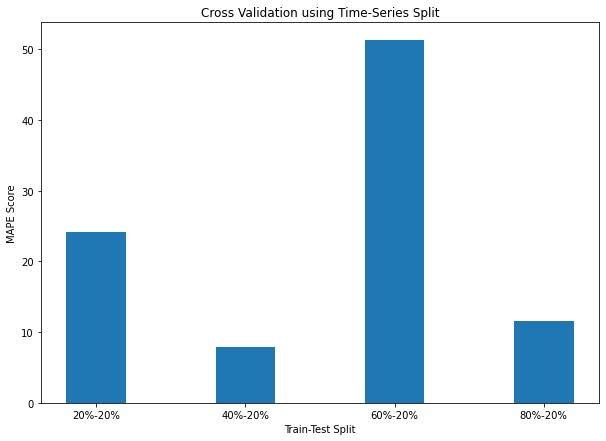

In [48]:
fig = plt.figure(figsize =(10, 7))
plt.bar(["20%-20%","40%-20%","60%-20%","80%-20%"], result, width = 0.4)
plt.title('Cross Validation using Time-Series Split', loc ='center')
plt.ylabel("MAPE Score")
plt.xlabel("Train-Test Split")

<AxesSubplot:xlabel='day'>

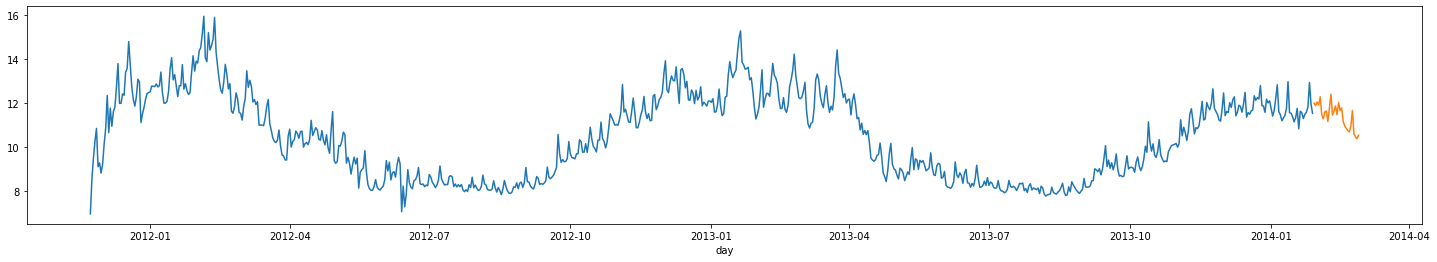

In [49]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))

In [50]:
#Autocorrelation and Partial Autocorrelation Graphs before differencing

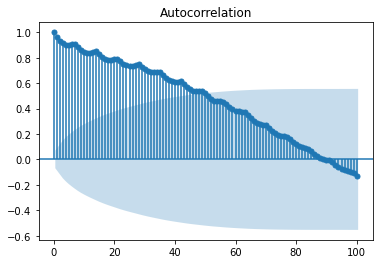

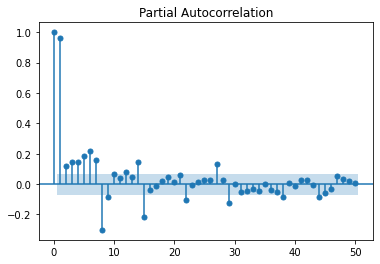

In [51]:
plot_acf(train.avg_energy,lags=100)
plot_pacf(train.avg_energy,lags=50)
plt.show()

In [52]:
#adfuller test for stationary data

In [53]:
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.905344
p-value                          0.329551
#Lags Used                      21.000000
Number of Observations Used    775.000000
dtype: float64

In [54]:
#differencing function

In [55]:
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [56]:
#Autocorrelation and Partial Autocorrelation Graphs after differencing

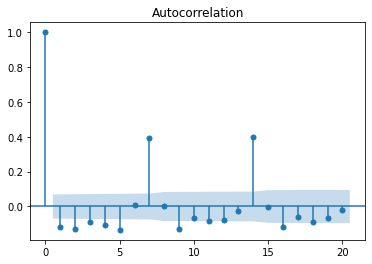

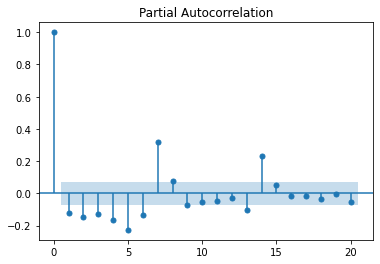

In [57]:
af = difference(train.avg_energy,1)
plot_acf(af,lags=20)
plot_pacf(af,lags=20)
#pyplot.plot(af)
plt.show()

In [58]:
#adfuller test for stationary data after differencing

In [59]:
t = sm.tsa.adfuller(difference(train.avg_energy,2), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -6.705607e+00
p-value                        3.792078e-09
#Lags Used                     2.100000e+01
Number of Observations Used    7.730000e+02
dtype: float64

In [60]:
#Seasonality

<AxesSubplot:xlabel='day'>

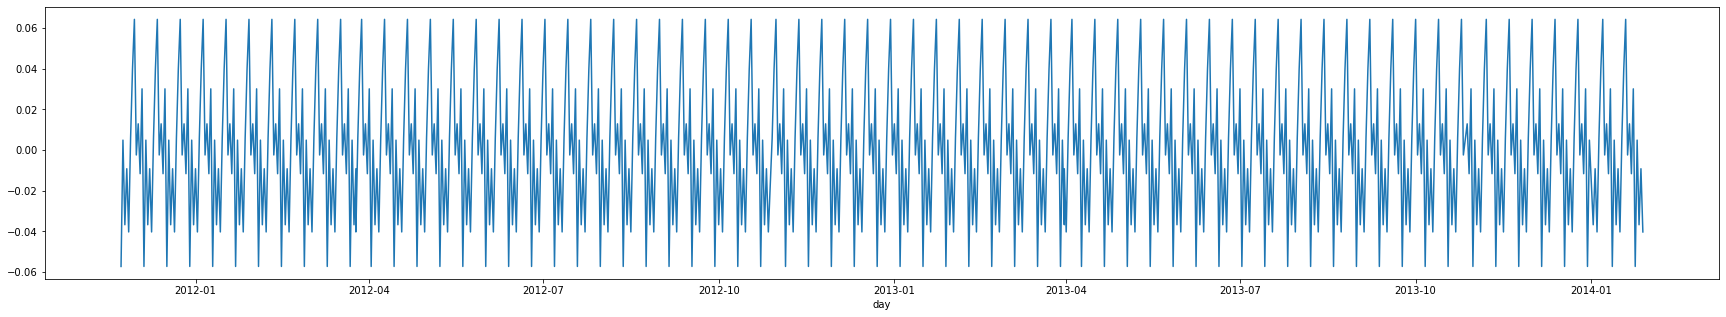

In [61]:
s = sm.tsa.seasonal_decompose(train.avg_energy,period=12)
s.seasonal.plot(figsize=(30,5))

In [62]:
#Trend

<AxesSubplot:xlabel='day'>

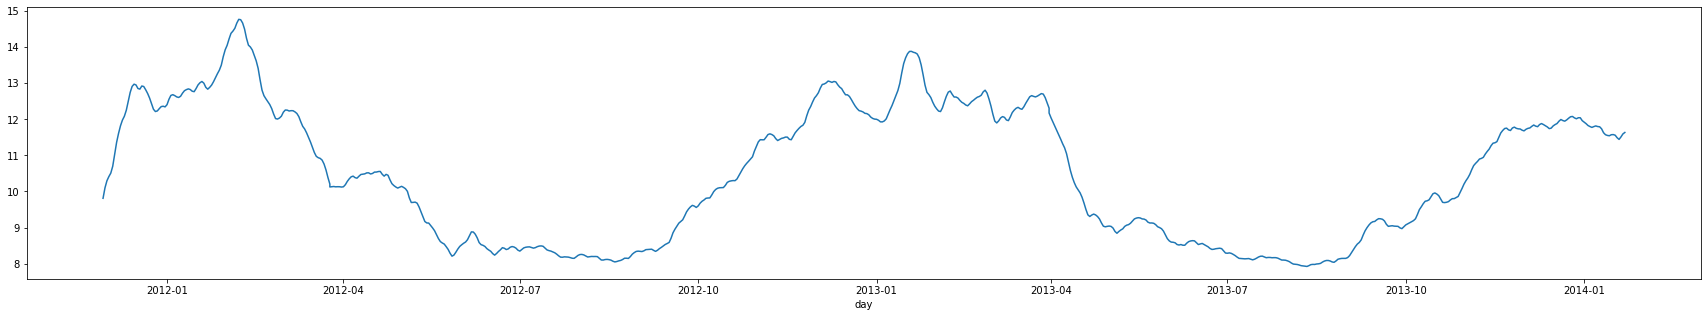

In [63]:
s.trend.plot(figsize=(30,5))

In [64]:
#Residual

<AxesSubplot:xlabel='day'>

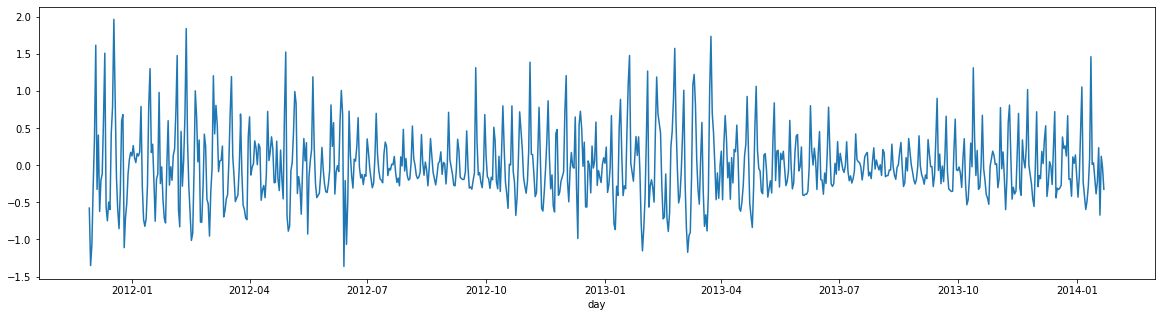

In [65]:
s.resid.plot(figsize=(20,5))

In [69]:
test.tail()

,avg_energy,weather_cluster
day,,
2014-02-23,11.673756,0
2014-02-24,10.586235,0
2014-02-25,10.476498,0
2014-02-26,10.375366,0
2014-02-27,10.537250,0


In [66]:
#Training Sarimax model

In [261]:
endog = train['avg_energy']
exog = sm.add_constant(train[['weather_cluster']])

mod = sm.tsa.statespace.SARIMAX(endog = endog,exog = exog, order=(7,1,7),seasonal_order=(1,1,0,12))
model_fit = mod.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          avg_energy   No. Observations:                  797
Model:             SARIMAX(7, 1, 7)x(1, 1, [], 12)   Log Likelihood                -581.211
Date:                             Thu, 13 Apr 2023   AIC                           1198.422
Time:                                     12:46:50   BIC                           1282.381
Sample:                                          0   HQIC                          1230.706
                                             - 797                                         
Covariance Type:                               opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -5.87e-08   8983.069  -6.53e-12      1.000   -1.76e+04    1.76e+04
weather_cluster    -0.0078      0.023     -0.338      0.735      -0.053       0.037
ar.L1               0.0358      0.053      0.675      0.500      -0.068       0.140
ar.L2              -0.1355      0.048     -2.808      0.005      -0.230      -0.041
ar.L3              -0.1143      0.053     -2.167      0.030      -0.218      -0.011
ar.L4              -0.0424      0.051     -0.827      0.408      -0.143       0.058
ar.L5              -0.1228      0.048     -2.546      0.011      -0.217      -0.028
ar.L6              -0.0459      0.049     -0.933      0.351      -0.142       0.051
ar.L7               0.7962      0.038     20.967      0.000       0.722       0.871
ma.L1              -0.2554      0.063     -4.073      0.000      -0.378      -0.133
ma.L2               0.0417      0.070      0.593      0.553      -0.096       0.179
ma.L3               0.0251      0.071      0.352      0.725      -0.115       0.165
ma.L4              -0.0565      0.075     -0.755      0.450      -0.203       0.090
ma.L5              -0.0213      0.070     -0.303      0.762      -0.159       0.117
ma.L6               0.0142      0.063      0.227      0.820      -0.108       0.137
ma.L7              -0.6521      0.052    -12.578      0.000      -0.754      -0.550
ar.S.L12           -0.4755      0.035    -13.506      0.000      -0.545      -0.406
sigma2              0.2521      0.011     23.810      0.000       0.231       0.273
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):                43.08
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [262]:
#Plot for fitted values

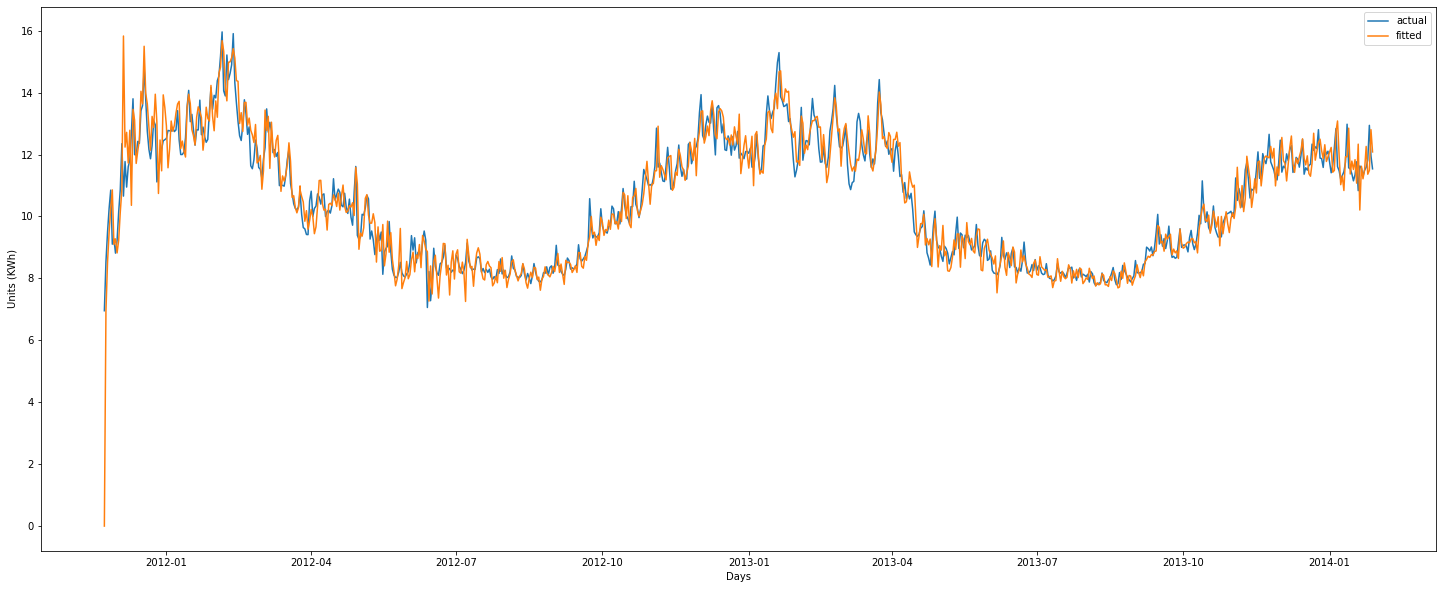

In [263]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.legend(["actual", "fitted"], loc ="upper right")
plt.ylabel("Units (KWh)")
plt.xlabel("Days")
plt.show()

In [264]:
#Prediction for next month

In [265]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_cluster']]))
test['predicted'] = predict.values
test.head(5)

,avg_energy,weather_cluster,predicted
day,,,
2014-01-29,12.002336,1,11.838764
2014-01-30,11.886982,1,11.178149
2014-01-31,12.051321,1,10.585164
2014-02-01,11.921217,2,11.504157
2014-02-02,12.291726,2,11.940311


In [266]:
#MAE and MAPE scores

In [267]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
rmse = math.sqrt(mean_squared_error(test['avg_energy'],test['predicted']))
print('Test RMSE: %.3f' % rmse)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("Test MAPE:", MAPE)


Test RMSE: 0.742
Test MAPE: 5.509533909261878


In [268]:
#Plot for actual vs predicted

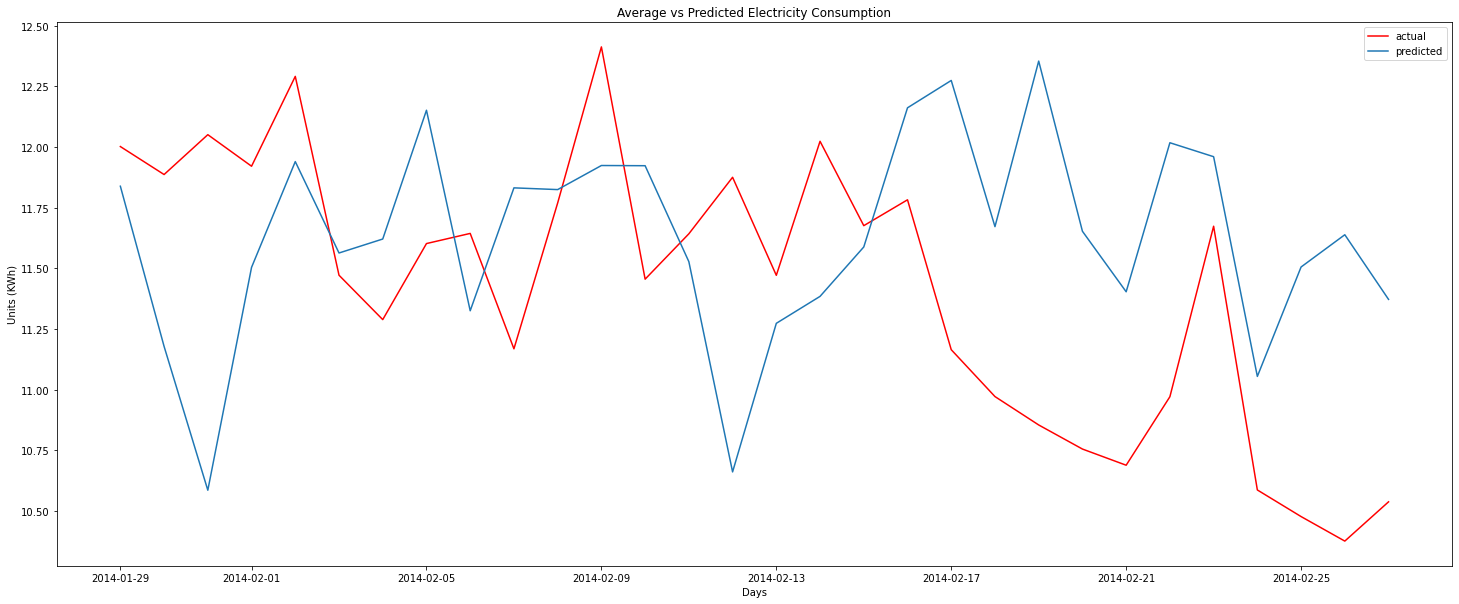

In [269]:
test['avg_energy'].plot(figsize=(25,10), color='red')
test['predicted'].plot()
plt.title("Average vs Predicted Electricity Consumption")
plt.legend(["actual", "predicted"], loc ="upper right")
plt.ylabel("Units (KWh)")
plt.xlabel("Days")
plt.show()

In [270]:
#Initializing data for LSTM model

In [271]:
np.random.seed(11)
dataframe = weather_electricity.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [272]:
#Function used to conver the data into a supervised data with lags upto 7 days

In [273]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [274]:
reframed = series_to_supervised(dataset, 7,1)

In [167]:
reframed['weather_cluster'] = weather_electricity.weather_cluster.values[7:]
reframed.head(5)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weather_cluster
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,2
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,0
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910,0
10,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910,10.862155,2
11,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910,10.862155,12.351882,2


In [168]:
reframed = reframed.reindex(['weather_cluster','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

In [ ]:
#Scaling Down values using MinMaxScaler

In [169]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)
reframed.shape

(820, 9)

In [ ]:
#Train-Test Splitting

In [170]:
train = reframed[:(len(reframed)-30), :]
test = reframed[(len(reframed)-30):len(reframed), :]

In [171]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X.shape

(790, 8)

In [ ]:
#Reshaping data into 3 dimensions as required by the keras sequential model

In [172]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(790, 1, 8) (790,) (30, 1, 8) (30,)


Epoch 1/100
12/12 - 2s - loss: 0.3536 - 2s/epoch - 129ms/step
Epoch 2/100
12/12 - 0s - loss: 0.2205 - 23ms/epoch - 2ms/step
Epoch 3/100
12/12 - 0s - loss: 0.1193 - 29ms/epoch - 2ms/step
Epoch 4/100
12/12 - 0s - loss: 0.0837 - 29ms/epoch - 2ms/step
Epoch 5/100
12/12 - 0s - loss: 0.0762 - 24ms/epoch - 2ms/step
Epoch 6/100
12/12 - 0s - loss: 0.0656 - 29ms/epoch - 2ms/step
Epoch 7/100
12/12 - 0s - loss: 0.0601 - 28ms/epoch - 2ms/step
Epoch 8/100
12/12 - 0s - loss: 0.0560 - 28ms/epoch - 2ms/step
Epoch 9/100
12/12 - 0s - loss: 0.0531 - 29ms/epoch - 2ms/step
Epoch 10/100
12/12 - 0s - loss: 0.0515 - 27ms/epoch - 2ms/step
Epoch 11/100
12/12 - 0s - loss: 0.0506 - 28ms/epoch - 2ms/step
Epoch 12/100
12/12 - 0s - loss: 0.0500 - 29ms/epoch - 2ms/step
Epoch 13/100
12/12 - 0s - loss: 0.0495 - 26ms/epoch - 2ms/step
Epoch 14/100
12/12 - 0s - loss: 0.0492 - 23ms/epoch - 2ms/step
Epoch 15/100
12/12 - 0s - loss: 0.0488 - 28ms/epoch - 2ms/step
Epoch 16/100
12/12 - 0s - loss: 0.0485 - 35ms/epoch - 3ms/step
E

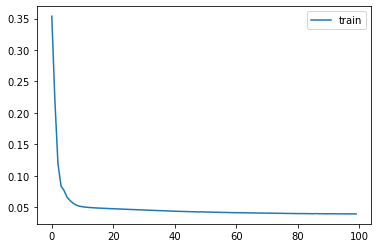

In [173]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=100, batch_size=70, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [174]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Predicting Values using LSTM model

In [175]:
yhat = model.predict(test_X)

1/1 [==============================] - 0s 352ms/step


In [176]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])
test_X.shape

(30, 8)

In [177]:
inv_yhat = np.concatenate((test_X,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat.shape

(30, 9)

In [178]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [179]:
act = [i[8] for i in inv_y] # last element is the predicted average energy
pred = [i[8] for i in inv_yhat] # last element is the actual average energy


In [180]:
pred = np.array(pred)
act = np.array(act)

In [181]:

rmse = math.sqrt(mean_squared_error(act, pred))
MAPE = (abs(act-pred)/pred).sum()*100/len(pred)
print("Test MAPE: ", MAPE)
print('Test RMSE: %.3f' % rmse)

Test MAPE:  2.8729634516501363
Test RMSE: 0.383


In [ ]:
#Plotting the Actual vs Predicted Values

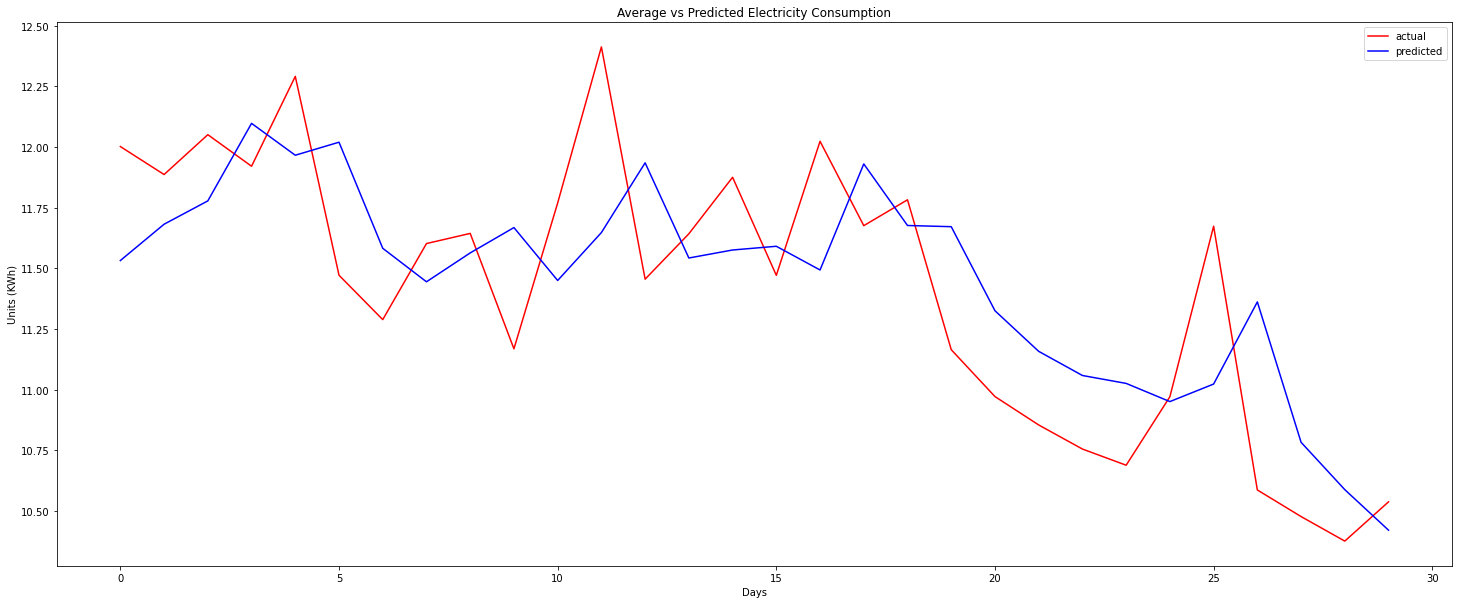

In [191]:
predicted_lstm = pd.DataFrame({'predicted':pred,'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(25,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')
plt.title("Average vs Predicted Electricity Consumption")
plt.legend(["actual", "predicted"], loc ="upper right")
plt.ylabel("Units (KWh)")
plt.xlabel("Days")
plt.show()

In [411]:
predicted_lstm.to_csv("lstmprediction.csv")
print("done")

done
